# Weather and Genomics Data

Note: Half datasets, with separate files for east and west subplots have been merged manually in excel

In [34]:
%%time

import os
import math
from datetime import datetime as dt
from datetime import timedelta as timedelta
import numpy as np
import pandas as pd
from copy import copy

# Dictionaries
import json
from pprint import pprint

# Iterate in loops
from itertools import zip_longest

# Simpsons integration
from numpy import trapz
from scipy.integrate import simps

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

# # For displaying max rows in series
# pd.options.display.max_rows = 10

Wall time: 997 µs


In [35]:
# Prints the current working directory
os.getcwd()
# os.listdir()

'C:\\Users\\fahad\\MegaSync\\NMBU\\GitHub\\vPheno'

## Finding Username folder to make general path for multi PC use

In [36]:
username = str(os.getcwd()).split('\\')[2]
user_path = r'C:/Users/'+username+'/'
username, user_path

('fahad', 'C:/Users/fahad/')

## Importing Data

In [37]:
main_path = r'./Data/'
path = r'./Data/2,2. renamed_merged/'
export_path = r'./Data/3. merged data/'
# temp_export_path = r'./Data/3. Temp_Data/'
weather_data_vollebekk = user_path+r'\\MegaSync\NMBU\Master Thesis\Data\Weather\Weather_Data_Ås-Vollebekk.csv'
weather_data_staur = user_path+r'\\MegaSync\NMBU\Master Thesis\Data\Weather\Weather_Data_Ilseng-Staur.csv'
genomics_data = user_path+r'\\MegaSync\NMBU\Master Thesis\Data\Genomics\\'

# Create export_path folder if not exists already
os.makedirs(path, exist_ok=True)
os.makedirs(export_path, exist_ok=True)
# os.makedirs(temp_export_path, exist_ok=True)

os.listdir(path)

['Graminor_2019_all.csv',
 'Graminor_2020_all.csv',
 'Masbasis_2019_all.csv',
 'Masbasis_2020_all_lodg.csv',
 'Robot_2020_all.csv',
 'Staur_2019_all.csv',
 'Staur_2020_all_lodg.csv']

## Data Preparation
### Creating list of complete files

In [38]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files found in the directory')
# files_with_address
files_list

7 files found in the directory


['Graminor_2019_all.csv',
 'Graminor_2020_all.csv',
 'Masbasis_2019_all.csv',
 'Masbasis_2020_all_lodg.csv',
 'Robot_2020_all.csv',
 'Staur_2019_all.csv',
 'Staur_2020_all_lodg.csv']

## Data Checking/control

### Check for duplicate filenames

In [39]:
print('Total number of files are :', len(files_list))

print('Number of unique file names are:', len(set(files_list)))

print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError

Total number of files are : 7
Number of unique file names are: 7
There is/are 0 duplicate file name/names.


## Importing data files to Pandas

In [40]:
   
%%time

all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("-", "_")
    file_name = file_name.replace(")", "")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(".", "")
    # Test: Check if the same date is already present in the current dict key
    if df_name in all_df:
        print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
        raise NameError
    all_df.append(df_name)

    locals()[df_name] = pd.read_csv(data, index_col=False)
    print(df_name, '=====', locals()[df_name].shape)
# all_df

Graminor_2019_all ===== (600, 381)
Graminor_2020_all ===== (800, 381)
Masbasis_2019_all ===== (528, 280)
Masbasis_2020_all_lodg ===== (659, 418)
Robot_2020_all ===== (96, 485)
Staur_2019_all ===== (1328, 181)
Staur_2020_all_lodg ===== (1504, 212)
Wall time: 619 ms


In [41]:
print(f'Total imported {len(all_df)}')
all_df

Total imported 7


['Graminor_2019_all',
 'Graminor_2020_all',
 'Masbasis_2019_all',
 'Masbasis_2020_all_lodg',
 'Robot_2020_all',
 'Staur_2019_all',
 'Staur_2020_all_lodg']

## Summary of imported data

In [42]:
for df in all_df:
    temp_df = locals()[df].copy()
    print(df, temp_df.shape)

Graminor_2019_all (600, 381)
Graminor_2020_all (800, 381)
Masbasis_2019_all (528, 280)
Masbasis_2020_all_lodg (659, 418)
Robot_2020_all (96, 485)
Staur_2019_all (1328, 181)
Staur_2020_all_lodg (1504, 212)


## GrainYield data 

In [43]:
# Masbasis_2019_Simps.info(null_counts=True)
for df in all_df:
    temp_df = locals()[df].copy()
#     print('*************', df, '**************')
#     print(locals()[df].info())

    print (df)
    print('Grain Yield data missing for ', temp_df['GrainYield'].isna().sum(), 'out of ', temp_df.shape[0])
# Graminor_2019_Simps.info()

Graminor_2019_all
Grain Yield data missing for  1 out of  600
Graminor_2020_all
Grain Yield data missing for  1 out of  800
Masbasis_2019_all
Grain Yield data missing for  6 out of  528
Masbasis_2020_all_lodg
Grain Yield data missing for  116 out of  659
Robot_2020_all
Grain Yield data missing for  0 out of  96
Staur_2019_all
Grain Yield data missing for  0 out of  1328
Staur_2020_all_lodg
Grain Yield data missing for  568 out of  1504


# Looking for zero values in data

In [44]:
# Masbasis_2019_Simps.info(null_counts=True)
for df in all_df:
    temp_df = locals()[df].copy()
    for col in temp_df.columns.to_list():
        if (temp_df[col]==0).sum() >0:
#             print(temp_df.columns.to_list())
            print(df, col, (temp_df[col]==0).sum())

Masbasis_2020_all_lodg Lodging 502
Staur_2020_all_lodg Lodging 157


# Importing Yield columns and Spectral Indices

In [45]:
a_file = open(main_path+"yield_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to dictionary
yield_cols = json.loads(output_str)
a_file.close()
print(yield_cols)

['Entry', 'Replicates', 'Name', 'Lodging', 'GrainYield', 'iBlock', 'Line', 'Pedigree', 'Block', 'Days2Maturity', 'CodeName', 'Heading_Date', 'Days2Heading', 'Maturity_Date']


In [46]:
a_file = open(main_path+"spectral_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to dictionary
spectral_indices = json.loads(output_str)
a_file.close()
print(spectral_indices)

['NDVI', 'MTCI', 'DVI', 'GDVI', 'MTCI_CI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR']


In [47]:
a_file = open(main_path+"base_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to dictionary
base_indices = json.loads(output_str)
a_file.close()
print(base_indices)

['Blue', 'Green', 'Red', 'RedEdge', 'NIR']


Zeros only present in Lodging columns where present in the dataset.

# Finding yield columns

In [48]:
# ToDo: Add check for duplicate columns in the df

base_indices

spectral_indices

yield_cols

id_cols_new = ['Plot_ID']

# Counter for location of column in columns list

# Dict for saving the name and location of the yield column/s
loc_yield_cols = {}
for df in all_df:
    loc = 0
    for cols in locals()[df].columns.tolist():
        for y_col in yield_cols:
            if not cols.find(y_col):
                loc_yield_cols[cols+'_'+df] = loc
                print(f'\"{cols}\" column in {df} is the yield column\n as it contains the text \"{y_col}\". It is located at location {loc}')
        loc += 1

    yield_cols_found = list(loc_yield_cols.keys())
    target_cols=yield_cols_found[0]
loc_yield_cols

"GrainYield" column in Graminor_2019_all is the yield column
 as it contains the text "GrainYield". It is located at location 6
"Block" column in Graminor_2019_all is the yield column
 as it contains the text "Block". It is located at location 7
"iBlock" column in Graminor_2019_all is the yield column
 as it contains the text "iBlock". It is located at location 8
"Entry" column in Graminor_2019_all is the yield column
 as it contains the text "Entry". It is located at location 9
"Name" column in Graminor_2019_all is the yield column
 as it contains the text "Name". It is located at location 10
"Pedigree" column in Graminor_2019_all is the yield column
 as it contains the text "Pedigree". It is located at location 11
"GrainYield" column in Graminor_2020_all is the yield column
 as it contains the text "GrainYield". It is located at location 6
"Block" column in Graminor_2020_all is the yield column
 as it contains the text "Block". It is located at location 7
"iBlock" column in Graminor_

{'GrainYield_Graminor_2019_all': 6,
 'Block_Graminor_2019_all': 7,
 'iBlock_Graminor_2019_all': 8,
 'Entry_Graminor_2019_all': 9,
 'Name_Graminor_2019_all': 10,
 'Pedigree_Graminor_2019_all': 11,
 'GrainYield_Graminor_2020_all': 6,
 'Block_Graminor_2020_all': 7,
 'iBlock_Graminor_2020_all': 8,
 'Entry_Graminor_2020_all': 9,
 'Name_Graminor_2020_all': 10,
 'Pedigree_Graminor_2020_all': 11,
 'GrainYield_Masbasis_2019_all': 6,
 'Replicates_Masbasis_2019_all': 7,
 'Block_Masbasis_2019_all': 8,
 'Name_Masbasis_2019_all': 9,
 'Line_Masbasis_2019_all': 10,
 'Days2Heading_Masbasis_2019_all': 11,
 'Days2Maturity_Masbasis_2019_all': 12,
 'GrainYield_Masbasis_2020_all_lodg': 6,
 'Replicates_Masbasis_2020_all_lodg': 7,
 'Block_Masbasis_2020_all_lodg': 8,
 'Name_Masbasis_2020_all_lodg': 9,
 'Line_Masbasis_2020_all_lodg': 10,
 'Maturity_Date_Masbasis_2020_all_lodg': 11,
 'Days2Heading_Masbasis_2020_all_lodg': 12,
 'Days2Maturity_Masbasis_2020_all_lodg': 13,
 'Lodging_Masbasis_2020_all_lodg': 14,
 'G

# Finding dates between heading and maturity

In [49]:
yield_cols

['Entry',
 'Replicates',
 'Name',
 'Lodging',
 'GrainYield',
 'iBlock',
 'Line',
 'Pedigree',
 'Block',
 'Days2Maturity',
 'CodeName',
 'Heading_Date',
 'Days2Heading',
 'Maturity_Date']

In [50]:
for df in all_df:
    temp_df = locals()[df].copy()
    if 'Days2Maturity' in temp_df.columns:
        print(df)
all_df

Masbasis_2019_all
Masbasis_2020_all_lodg
Robot_2020_all
Staur_2019_all


['Graminor_2019_all',
 'Graminor_2020_all',
 'Masbasis_2019_all',
 'Masbasis_2020_all_lodg',
 'Robot_2020_all',
 'Staur_2019_all',
 'Staur_2020_all_lodg']

## Declaring the important dates for each field

In [51]:
# Dates listed in dict in order; sowing, heading, maturity
# The order of fields must be the same as in all_df list
# sowing_dict = {
#     'Graminor_2019': ['240419', 'XX', 'XX'],
#     'Graminor_2020': ['150420', 'XX', 'XX'],
#     'Masbasis_2019': ['190519', 'XX', 'XX'],
#     'Masbasis_2020': ['150520', 'XX', 'XX'],
#     'Robot_2020': ['200420', '170620', '310720'],
#     'Staur_2019': ['040619', 'XX', 'XX'],
#     'Staur_2020': ['210420', 'XX', 'XX'],
# }

sowing_dict = {
    'Graminor_2019': '240419',
    'Graminor_2020': '150420',
    'Masbasis_2019': '190519',
    'Masbasis_2020': '150520',
    'Robot_2020': '200420',
    'Staur_2019': '040619',
    'Staur_2020': '210420',
}


## Filtering df which have Days2Maturity and Days2Heading 

In [52]:
# If the dataset had Days 2 heading and days to maturity columns then create the
# following dictionary with the respective sowing dates of each field as value
all_df_sowing = {}

for df in all_df:
    temp_df = locals()[df].copy()
    field_temp = df.split('_')[0]+'_'+df.split('_')[1]
#     if 'Days2Heading' in temp_df.columns and 'Days2Maturity' in temp_df.columns:
#         print(df)
#         all_df_sowing[df] = sowing_dict[field_temp]
    all_df_sowing[df] = sowing_dict[field_temp]

all_df_sowing

{'Graminor_2019_all': '240419',
 'Graminor_2020_all': '150420',
 'Masbasis_2019_all': '190519',
 'Masbasis_2020_all_lodg': '150520',
 'Robot_2020_all': '200420',
 'Staur_2019_all': '040619',
 'Staur_2020_all_lodg': '210420'}

## Average DH and DM

In [53]:
# Creating a dictionary with average Days2Heading and Days2Maturity for fields whose data is available
dict_avg_dh_dm = {}
df_dh_dm = []
for df in all_df_sowing.keys():
    temp_df = locals()[df].copy()

#     print('Days2Heading')
#     print(locals()[df].Days2Heading.min(), ':      ', locals()[df].Days2Heading.max(), ':     ', locals()[df].Days2Heading.mean())
#     print('Days2Maturity')
#     print(locals()[df].Days2Maturity.min(), ':      ', locals()[df].Days2Maturity.max(), ':     ', locals()[df].Days2Maturity.mean())

    if 'Days2Heading' in temp_df.columns and 'Days2Maturity' in temp_df.columns:
        df_dh_dm.append(df)
        dict_avg_dh_dm[df] = [locals()[df].Days2Heading.mean(), locals()[df].Days2Maturity.mean()]
dict_avg_dh_dm


{'Masbasis_2019_all': [68.18939393939394, 108.64393939393939],
 'Masbasis_2020_all_lodg': [66.28983308042488, 87.94881170018282],
 'Robot_2020_all': [61.09375, 110.84375],
 'Staur_2019_all': [48.53333333333333, 101.25757575757575]}

In [54]:
from statistics import mean

list_dh = []
list_dm = []
for field, dhdm in dict_avg_dh_dm.items():
    list_dh.append(dhdm[0])
    list_dm.append(dhdm[1])
mean_dh = mean(list_dh)
mean_dm = mean(list_dm)
print(f'Average Days2Heading is {mean_dh}')
print(f'Average Days2Maturity is {mean_dm}')


Average Days2Heading is 61.026577588288035
Average Days2Maturity is 102.17351921292449


# Integration

In [55]:
from scipy.integrate import simps
from numpy import trapz
from scipy.integrate import cumulative_trapezoid
from scipy.integrate import romb

ImportError: cannot import name 'cumulative_trapezoid' from 'scipy.integrate' (C:\Users\fahad\AppData\Roaming\Python\Python38\site-packages\scipy\integrate\__init__.py)

## Testing different alternatives

In [56]:
# simps(temp_entries_dropna, days_sow)

In [57]:
# days_sow

# days = [50, 64, 72, ((72 + 87) / 2), 87]
# band = [21, 14, 9, ((9 + 2) / 2), 2]

# days2 = [50, 64, 72, 87]
# band2 = [21, 14, 9, 2]

# simps(band, days), simps(band2, days2), 

In [58]:
# temp_entries_dropna

In [59]:
all_df

['Graminor_2019_all',
 'Graminor_2020_all',
 'Masbasis_2019_all',
 'Masbasis_2020_all_lodg',
 'Robot_2020_all',
 'Staur_2019_all',
 'Staur_2020_all_lodg']

## Creating df with Plot_ID and Grain_Yield only
## Calculating AUC and creating new df with calculated values

In [60]:
simp_df_all = []
trapz_df_all = []
samples_record_simps = {}
for df, sowing in all_df_sowing.items():

    temp_df = locals()[df].copy()
    cols = temp_df.columns
    
    # Creating a list of columns which other than the indices (ID and yield columns)
    # Making a temp list of yield columns since all entries from yield cols are not present in every df
    temp_yield_cols = [x for x in temp_df.columns if x in yield_cols]
    non_indices_cols = id_cols_new+temp_yield_cols
#     print(non_indices_cols)
    
    df_auc_simps = temp_df[non_indices_cols].copy()
    df_auc_trapz = temp_df[non_indices_cols].copy()
#     display(df_auc.head())

    # Calculating AUC and creating new df with calculated values
    temp_samples = {}
    for col_name in base_indices+spectral_indices:
        df_simp = []
        df_trapz = []
        # Making temp_cols list avoids problems finding and differentiating 'OSAVI' and 'GOSAVI'
        temp_cols = [x for x in cols if col_name.split('_') == x.split('_')[:-1]]
        temp_dates = [dt.strptime(date.split('_')[-1], '%d%m%y').date() for date in temp_cols]

        # Calculating the days from sowing,i.e. age of the crop in days
        sowing_date = dt.strptime(sowing, '%d%m%y').date() 
        
        temp_samples_list = []
        for sample in range(temp_df.shape[0]):
            # Number of days since sowing for each entry
            days_sow = [(x-sowing_date).days for x in temp_dates]
            # The respective value of the index in question 
            temp_entries = [temp_df[x][sample] for x in temp_cols]

            #### DROPPING DATES OUTSIDE HEADING AND MATURITY DATES ####
            
            # Determining Days2Heading values
            if 'Days2Heading' in temp_df.columns:
                # Days to heading for current sample 
                DH = temp_df.Days2Heading[sample]
                # If DH is missing then use the smallest of Mean DH from fields whose DH is available
                if str(DH)=='nan':
                    DH = round(min(list_dh))
            else:
                DH = round(min(list_dh))
                
                
                
                
            if 'Days2Maturity' in temp_df.columns:
                # Days to maturity for current sample 
                DM = temp_df.Days2Maturity[sample]
                # If DM is missing then use the largest of Mean DM from fields whose DM is available
                if str(DM)=='nan':
                    DM = round(max(list_dm))
            else:
                DM = round(max(list_dm))  
                    
            DH = int(DH)
            DM = int(DM)
            # Making sure that the maturity comes after heading
            if DM < DH:
                print(DM, DH)
            assert DM > DH
#             print(DM, DH)
            heading_date = sowing_date + timedelta(days=DH)
            maturity_date = sowing_date + timedelta(days=DM)
            
            # Replacing the respective values of items in temp_entries with np.nan which correspond 
            # to dates not in between heading and maturity for that specific sub-plot
#             temp_entries_filtered = [y if heading_date <= x <= maturity_date else np.nan for x,y in zip(temp_dates, temp_entries)]
            
            ## CHANGE: REMOVING LIMIT FOR HEADING DATE. USING ALL DATA BEFORE MATURITY
            temp_entries_filtered = [y if x <= maturity_date else np.nan for x,y in zip(temp_dates, temp_entries)]

            # Dropping missing(nan) values from the entries
            temp_entries_dropna = [x for x in temp_entries_filtered if str(x) != 'nan']
            days_before_dropping = days_sow.copy()
            # Checking if the number of items in temp_entries_filtered and days_sow is the same
            # If not, i.e., there are missing values(nan) in temp_entries_filtered then drop the
            # respective entries from days_sow list
            if not len(temp_entries_dropna) == len(days_sow):
                # Dictionary comprehension
                # Creating dictionary(dict comprehension) where temp_entries_filtered are not nan
                dict_dropna = {i: [temp_entries_filtered[i], days_sow[i]] for i in range(len(temp_entries_filtered))\
                       if not str(temp_entries_filtered[i]) == 'nan' }
                
                # Checking if the previously created temp_entries_dropna is the same as the new that will
                # be created from dict_dropna (Unnecessary check but curious to check if any problems arise)
                assert temp_entries_dropna == [dict_dropna[i][0] for i in dict_dropna.keys()]
                
                # Creating new temp entries and days_sow after dropping nan and respective entries in days_sow
                temp_entries_dropna = [dict_dropna[i][0] for i in dict_dropna.keys()]
                days_sow = [dict_dropna[i][1] for i in dict_dropna.keys()]

            # Checking if the lists have the same number of entries
            if len(temp_entries_dropna) != len(days_sow):
                print(df, col_name, temp_entries, days_before_dropping, temp_entries_dropna, days_sow, dict_dropna)
            assert len(temp_entries_dropna) == len(days_sow)
            
            # Sorting both lists with dates in ascending order
            days_sow, temp_entries_dropna = zip(*sorted(zip(days_sow, temp_entries_dropna)))
            
            simps_value = simps(temp_entries_dropna, days_sow)
            trapz_value = trapz(temp_entries_dropna, days_sow)
            
            df_simp.append(simps_value)
            df_trapz.append(trapz_value)
            
#             if simps_value == 0:
#                 print(temp_entries_filtered, days_before_dropping, temp_entries_dropna, days_sow)
            # Adding values to a list for reference and record to verify the results and identify problems later
            temp_samples_list.append([df, col_name, temp_df['Plot_ID'][sample], simps_value, temp_entries_dropna, days_sow])
        temp_samples[col_name] = temp_samples_list

        # Insert the new column at the end, but before GrainYield
        df_auc_simps.insert(len(df_auc_simps.columns)-1, col_name, df_simp)
        df_auc_trapz.insert(len(df_auc_trapz.columns)-1, col_name, df_trapz)
        
    samples_record_simps[df.split('_')[0]+'_'+df.split('_')[1]] = temp_samples

    # Adding the new name of the df to a list named simp_df_all
    simp_df = df.split('_')[0]+'_'+df.split('_')[1]+'_Simps'
    trapz_df = df.split('_')[0]+'_'+df.split('_')[1]+'_Trapz'

    simp_df_all.append(simp_df)
    trapz_df_all.append(trapz_df)
    print(simp_df, df_auc_simps.shape, trapz_df, df_auc_trapz.shape)
    locals()[simp_df] = df_auc_simps.copy()
    locals()[trapz_df] = df_auc_trapz.copy()
# simp_df_all, trapz_df_all

Graminor_2019_Simps (600, 41) Graminor_2019_Trapz (600, 41)
Graminor_2020_Simps (800, 41) Graminor_2020_Trapz (800, 41)
Masbasis_2019_Simps (528, 42) Masbasis_2019_Trapz (528, 42)
Masbasis_2020_Simps (659, 44) Masbasis_2020_Trapz (659, 44)
Robot_2020_Simps (96, 43) Robot_2020_Trapz (96, 43)
Staur_2019_Simps (1328, 45) Staur_2019_Trapz (1328, 45)
Staur_2020_Simps (1504, 42) Staur_2020_Trapz (1504, 42)


In [61]:
# Masbasis_2020_all_lodg[[x for x in Masbasis_2020_all_lodg.columns if 'EVI' in x]+['Plot_ID']].head(150)

In [62]:
samples_record_simps.keys()

dict_keys(['Graminor_2019', 'Graminor_2020', 'Masbasis_2019', 'Masbasis_2020', 'Robot_2020', 'Staur_2019', 'Staur_2020'])

In [63]:
temp_entries_dropna, days_sow

((3.991561550234313,
  13.550267393424521,
  12.97462438907558,
  8.757489999068124,
  6.443754326877627,
  4.2849224878608485),
 (60, 65, 79, 86, 94, 101))

In [64]:
# samples_record_simps['Masbasis_2020']['EVI'][149]

In [32]:
all_df

['Graminor_2019_all',
 'Graminor_2020_all',
 'Masbasis_2019_all',
 'Masbasis_2020_all_lodg',
 'Robot_2020_all',
 'Staur_2019_all',
 'Staur_2020_all_lodg']

In [33]:
from pycaret.anomaly import *
s = setup(Robot_2020_all, session_id = 123)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,02:26:20
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Plot_ID,Numeric
Blue_120820,Numeric
Green_120820,Numeric
Red_120820,Numeric
RedEdge_120820,Numeric
...,...
MSAVI2_180620,Numeric
MSR_180620,Numeric
GRVI_180620,Numeric
WDRVI_180620,Numeric


KeyboardInterrupt: Interrupted by user

In [ ]:
iforest = create_model('iforest', fraction = 0.1)
iforest_results = assign_model(iforest)
iforest_results.head()

In [ ]:
iforest_results[iforest_results['Anomaly'] == 1].head()


In [ ]:
import plotly.graph_objects as go
# plot value on y-axis and date on x-axis
fig = px.line(iforest_results, x=iforest_results.index, y="value", title='NYC TAXI TRIPS - UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index
# obtain y value of anomalies to plot
y_values = [iforest_results.loc[i]['value'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

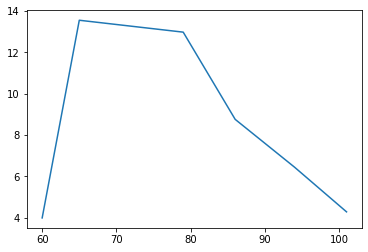

In [69]:
plt.plot(days_sow, temp_entries_dropna)

In [70]:
temp_entries_dropna, days_sow

((3.991561550234313,
  13.550267393424521,
  12.97462438907558,
  8.757489999068124,
  6.443754326877627,
  4.2849224878608485),
 (60, 65, 79, 86, 94, 101))

## Looking for Zero values in data

In [33]:
# Masbasis_2019_Simps.info(null_counts=True)
for df in simp_df_all+trapz_df_all:
    temp_df = locals()[df][base_indices+spectral_indices].copy()
    for col in temp_df.columns.to_list():
        if (temp_df[col]==0).sum() >0:
#             print(temp_df.columns.to_list())
            print(df, col, (temp_df[col]==0).sum())

In [34]:
# Plot_ID, simps_value, trapz_value, temp_cols, temp_dates, sowing_date, DH, DM, heading_date, maturity_date, temp_entries, days_before, temp_entries_dropna, days_sow])

list_problem = []
pprint(samples_record_simps['Masbasis_2019'].keys())
for keya, data in samples_record_simps['Masbasis_2019'].items():
    for x in data:
        if x [1]==0:
            temp_entries = x[10]
            days_sow = x[11]
#             simps(xx,dd)
            sowing_date = x[5]
            DH = x[6]
            DM = x[7]
            temp_dates = x[4]
            heading_date= x[8]
            maturity_date = x[9]
#             print(x[0], x[5])
#             print(x)
            list_problem.append(x[0])
            temp_entries_filtered = [x if heading_date <= x <= maturity_date else np.nan for x,y in zip(temp_dates, temp_entries)]
            print(heading_date.strftime('%d%m%y'),[x.strftime('%d%m%y') for x in temp_dates],  maturity_date.strftime('%d%m%y'))
            print('************************')

dict_keys(['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI', 'DVI', 'GDVI', 'MTCI_CI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR'])


In [35]:

temp_entries_filtered = [y if heading_date <= x <= maturity_date else np.nan for x,y in zip(temp_dates, temp_entries)]
temp_entries_filtered
# 
sowing_date, DH, DM, heading_date, maturity_date, temp_dates

(datetime.date(2020, 4, 21),
 49,
 111,
 datetime.date(2020, 6, 9),
 datetime.date(2020, 8, 10),
 [datetime.date(2020, 7, 31),
  datetime.date(2020, 7, 24),
  datetime.date(2020, 7, 16),
  datetime.date(2020, 7, 9),
  datetime.date(2020, 6, 25),
  datetime.date(2020, 6, 20)])

In [36]:
temp_entries

[4.2849224878608485,
 6.443754326877627,
 8.757489999068124,
 12.97462438907558,
 13.550267393424521,
 3.991561550234313]

In [37]:
blu_cols = [x for x in Masbasis_2019_all.columns if 'Blue' in x]

Masbasis_2019_all['Plot_ID']
Masbasis_2019_all.iloc[95:96,:][blu_cols]

# list_problem

,Blue_070819,Blue_290719,Blue_220719,Blue_150719,Blue_050719,Blue_280619,Blue_260619,Blue_060619
95,0.027306,0.016146,0.014434,0.023842,0.009863,0.015405,0.021012,0.024337


In [38]:
idx_found = []
for x in list_problem:
    idx_found.append(int(Masbasis_2019_all[Masbasis_2019_all['Plot_ID']==x].index.values))
#     print()
Masbasis_2019_all.iloc[idx_found,:][['Plot_ID']+blu_cols]
# idx_found

,Plot_ID,Blue_070819,Blue_290719,Blue_220719,Blue_150719,Blue_050719,Blue_280619,Blue_260619,Blue_060619


In [39]:
# df['Plot_ID']==x
type(x)

list

## Dropping Missing values

In [40]:
df_dh_dm

['Masbasis_2019_all',
 'Masbasis_2020_all_lodg',
 'Robot_2020_all',
 'Staur_2019_all']

In [41]:
# Masbasis_2019_Simps.info(null_counts=True)
for df in simp_df_all:
    temp_df = locals()[df].copy()
#     print('*************', df, '**************')
#     print(locals()[df].info())

    print (df)
    print('Grain Yield data missing for ', temp_df['GrainYield'].isna().sum(), 'out of ', temp_df.shape[0])
# Graminor_2019_Simps.info()

Graminor_2019_Simps
Grain Yield data missing for  1 out of  600
Graminor_2020_Simps
Grain Yield data missing for  1 out of  800
Masbasis_2019_Simps
Grain Yield data missing for  6 out of  528
Masbasis_2020_Simps
Grain Yield data missing for  116 out of  659
Robot_2020_Simps
Grain Yield data missing for  0 out of  96
Staur_2019_Simps
Grain Yield data missing for  0 out of  1328
Staur_2020_Simps
Grain Yield data missing for  568 out of  1504


Yield data of Staur 2020 is disjoint with the bands data. There are 568 subplots whose yield is not available in the yield file and there are 10 subplots in the yield data which are not in the bands data sheets.


There are atleast 116 missing grain yield values in Masbasis 2020 yield dataset.

In [42]:
simp_df_all_dropna = []
for df in simp_df_all:
    temp_df = locals()[df].copy()
    rows = temp_df.shape[0]
#     print(temp_df.shape)
    temp_df.dropna(subset=['Blue'],inplace = True)
    print(df, 'Dropped entries', rows- temp_df.shape[0],':', rows, temp_df.shape[0])
    new_df = df+'_dropna'
    locals()[new_df] = temp_df.copy()
    simp_df_all_dropna.append(new_df)
simp_df_all_dropna

Graminor_2019_Simps Dropped entries 0 : 600 600
Graminor_2020_Simps Dropped entries 0 : 800 800
Masbasis_2019_Simps Dropped entries 0 : 528 528
Masbasis_2020_Simps Dropped entries 0 : 659 659
Robot_2020_Simps Dropped entries 0 : 96 96
Staur_2019_Simps Dropped entries 0 : 1328 1328
Staur_2020_Simps Dropped entries 0 : 1504 1504


['Graminor_2019_Simps_dropna',
 'Graminor_2020_Simps_dropna',
 'Masbasis_2019_Simps_dropna',
 'Masbasis_2020_Simps_dropna',
 'Robot_2020_Simps_dropna',
 'Staur_2019_Simps_dropna',
 'Staur_2020_Simps_dropna']

In [43]:
trapz_df_all_dropna = []
for df in trapz_df_all:
    temp_df = locals()[df].copy()
    rows = temp_df.shape[0]
#     print(temp_df.shape)
    temp_df.dropna(subset=['Blue'],inplace = True)
    print(df, 'Dropped entries', rows- temp_df.shape[0],':', rows, temp_df.shape[0])
    new_df = df+'_dropna'
    locals()[new_df] = temp_df.copy()
    trapz_df_all_dropna.append(new_df)
trapz_df_all_dropna

Graminor_2019_Trapz Dropped entries 0 : 600 600
Graminor_2020_Trapz Dropped entries 0 : 800 800
Masbasis_2019_Trapz Dropped entries 0 : 528 528
Masbasis_2020_Trapz Dropped entries 0 : 659 659
Robot_2020_Trapz Dropped entries 0 : 96 96
Staur_2019_Trapz Dropped entries 0 : 1328 1328
Staur_2020_Trapz Dropped entries 0 : 1504 1504


['Graminor_2019_Trapz_dropna',
 'Graminor_2020_Trapz_dropna',
 'Masbasis_2019_Trapz_dropna',
 'Masbasis_2020_Trapz_dropna',
 'Robot_2020_Trapz_dropna',
 'Staur_2019_Trapz_dropna',
 'Staur_2020_Trapz_dropna']

Old:  
Masbasis_2019_Trapz Dropped entries 0 : 528 528  
Masbasis_2020_Trapz Dropped entries 112 : 659 547  
Robot_2020_Trapz Dropped entries 0 : 96 96  
Staur_2019_Trapz Dropped entries 1166 : 1328 162  

In [44]:
def describe_nan(df):
    return pd.DataFrame([(i, df[df[i].isna()].shape[0],df[df[i].isna()].shape[0]/df.shape[0]) for i in df.columns], columns=['column', 'nan_counts', 'nan_rate'])
for df in simp_df_all_dropna+trapz_df_all_dropna:
    print(df)
    display(describe_nan(locals()[df][base_indices+spectral_indices+['GrainYield']]).nan_counts.sum())
#     display(describe_nan(locals()[df][base_indices+spectral_indices+['GrainYield']]))

Graminor_2019_Simps_dropna


1

Graminor_2020_Simps_dropna


1

Masbasis_2019_Simps_dropna


6

Masbasis_2020_Simps_dropna


116

Robot_2020_Simps_dropna


0

Staur_2019_Simps_dropna


0

Staur_2020_Simps_dropna


568

Graminor_2019_Trapz_dropna


1

Graminor_2020_Trapz_dropna


1

Masbasis_2019_Trapz_dropna


6

Masbasis_2020_Trapz_dropna


116

Robot_2020_Trapz_dropna


0

Staur_2019_Trapz_dropna


0

Staur_2020_Trapz_dropna


568

# Weather Data

## Correcting datetime format

### Vollebekk

In [45]:
weather_vollebekk = pd.read_csv(weather_data_vollebekk)

# Converting date time to python datetime
weather_vollebekk['Time measured'] = pd.to_datetime(weather_vollebekk['Time measured'], infer_datetime_format=True)
# weather_vollebekk['Time measured'] = weather_vollebekk['Time measured'].dt.normalize()

# Removing timezone info from datetime sice other date data is without timezone info
weather_vollebekk['Time measured'] = pd.Series(x.replace(tzinfo=None) for x in weather_vollebekk['Time measured'])

weather_vollebekk.columns

Index(['Time measured', 'Middeltemperatur i 2m høyde (TM)',
       'Maksimum lufttemperatur i 2m høyde (TX)',
       'Minimums lufttemperatur i 2m høyde (TN)', 'Nedbør (RR)',
       'Relativ luftfuktighet i 2m', 'Relativ luftfuktighet i 2m.1',
       'Bladfuktighet i 2m høyde (BT)', ' 10 min glidende middel (FF2)',
       ' vindkast (FG2)', 'Vindhastighet i 2m'],
      dtype='object')

#### Vollebekk: Dropping the two xolumns whixh are not in staur weather data

In [46]:
weather_vollebekk.drop(['Bladfuktighet i 2m høyde (BT)', ' 10 min glidende middel (FF2)'], axis='columns', inplace=True)
weather_vollebekk.columns

Index(['Time measured', 'Middeltemperatur i 2m høyde (TM)',
       'Maksimum lufttemperatur i 2m høyde (TX)',
       'Minimums lufttemperatur i 2m høyde (TN)', 'Nedbør (RR)',
       'Relativ luftfuktighet i 2m', 'Relativ luftfuktighet i 2m.1',
       ' vindkast (FG2)', 'Vindhastighet i 2m'],
      dtype='object')

### Staur

In [47]:
weather_staur = pd.read_csv(weather_data_staur)

# Converting date time to python datetime
weather_staur['Time measured'] = pd.to_datetime(weather_staur['Time measured'], infer_datetime_format=True)
# weather_staur['Time measured'] = weather_staur['Time measured'].dt.normalize()

# Removing timezone info from datetime sice other date data is without timezone info
weather_staur['Time measured'] = pd.Series(x.replace(tzinfo=None) for x in weather_staur['Time measured'])

weather_staur.columns

Index(['Time measured', 'Middeltemperatur i 2m høyde (TM)',
       'Maksimum lufttemperatur i 2m høyde (TX)',
       'Minimums lufttemperatur i 2m høyde (TN)', 'Nedbør (RR)',
       'Relativ luftfuktighet i 2m', 'Relativ luftfuktighet i 2m.1',
       ' vindkast (FG2)', 'Vindhastighet i 2m'],
      dtype='object')

## Checking if both weather datas have same colummns

In [48]:
assert weather_vollebekk.columns.tolist() == weather_staur.columns.tolist()

## Translating column names

In [49]:
# Translated the column heading using google translate


weather_vollebekk.columns = ['Time measured', 'Average temperature at 2m altitude (TM)',
        'Maximum air temperature at 2m altitude (TX)',
        'Minimum air temperature at 2m altitude (TN)', 'Precipitation (RR)',
        'Relative humidity in 2m', 'Relative humidity in 2m.1',
        'Wind gust (FG2)', 'Wind speed in 2m']


# Translated the column heading using google translate

weather_staur.columns = ['Time measured', 'Average temperature at 2m altitude (TM)',
        'Maximum air temperature at 2m altitude (TX)',
        'Minimum air temperature at 2m altitude (TN)', 'Precipitation (RR)',
        'Relative humidity in 2m', 'Relative humidity in 2m.1',
        'Wind gust (FG2)', 'Wind speed in 2m']

## Craeting a list of min and max date in every field

In [50]:
max_min_dates = {}
for df in all_df:
    temp_df = locals()[df].copy()
    dates = [x.split('_')[1] for x in temp_df.columns if 'Blue' in x]
    df_name_temp = df.split('_')[0]+'_'+df.split('_')[1]
    sowing_date_temp = dt.strptime(sowing_dict[df_name_temp], '%d%m%y')
    min_date_temp = min([dt.strptime(x, '%d%m%y') for x in dates ])
    max_date_temp = max([dt.strptime(x, '%d%m%y') for x in dates ])
    max_min_dates[df] = [sowing_date_temp, min_date_temp, max_date_temp]
# max_min_dates

## Calculating average DH and DM

In [51]:
dict_avg_dh_dm

{'Masbasis_2019_all': [68.18939393939394, 108.64393939393939],
 'Masbasis_2020_all_lodg': [66.28983308042488, 87.94881170018282],
 'Robot_2020_all': [61.09375, 110.84375],
 'Staur_2019_all': [48.53333333333333, 101.25757575757575]}

In [52]:
print(f'Average Days2Heading is {mean_dh}')
print(f'Average Days2Maturity is {mean_dm}')

Average Days2Heading is 61.026577588288035
Average Days2Maturity is 102.17351921292449


## Filtering weather data

In [53]:
# Weather data for days from sowing date. Largerst of the average number of Days2Maturity 
# is a good measaure to use
# Could have used max_date(last date availabel for the field) but that date does not 
# correspond to the actual crop maturity.
# So using approxipame maturity time is a better measure of the affect of weather on yield
days_delta = max(list_dm)

weather_dfs = []
weathers_processed_df = []
for df, dates in max_min_dates.items():
    df_weather_temp = pd.DataFrame()

    sowing_date_temp = dates[0]
    min_date_temp = dates[1]
    max_date_temp = dates[2]
    
    if 'Staur' in df:
        # Filtering the weather date from sowing_date to max_date the data is available for
        temp_weather = weather_staur.loc[(weather_staur['Time measured'] >= sowing_date_temp) &\
                              (weather_staur['Time measured'] <= sowing_date_temp + timedelta(days=days_delta))]
        # Filling the missing values with the average value of the area for the given complete weather data
        temp_weather.fillna(weather_staur.mean(), inplace = True)

    else:
        # Filtering the weather date from sowing_date to max_date the data is available for
        temp_weather = weather_vollebekk.loc[(weather_vollebekk['Time measured'] >= sowing_date_temp) &\
                              (weather_vollebekk['Time measured'] <= sowing_date_temp + timedelta(days=days_delta))]
        # Filling the missing values with the average value of the area for the given complete weather data
        temp_weather.fillna(weather_vollebekk.mean(), inplace = True)

#     print(df, sowing_date_temp.date(), min_date_temp.date(), max_date_temp.date())
#     print(temp_weather.shape)

#     # See info to find hoe many missing values and in which column
#     display(temp_weather.info())

    # Filling themissing values with the average of the column
    # Applying Only on columns with NaN values
    for i in temp_weather.columns[temp_weather.isnull().any(axis=0)]:
        temp_weather[i].fillna(temp_weather[i].mean(),inplace=True)
    # Drop the time measures column
    temp_weather.drop(['Time measured'], axis=1, inplace=True)
    
    df_weat_temp = df.split('_')[0]+'_'+df.split('_')[1]+'_weather_all'
    locals()[df_name_temp] = temp_weather.copy()
    weather_dfs.append(df_name_temp)
    
    
    
    # Aggregating the weather data using several statistical methods
    mean_df = temp_weather.mean().to_frame().transpose().add_prefix('MEAN ')
    median_df = temp_weather.median().to_frame().transpose().add_prefix('MEDIAN ')
    # Different for mode since mode returns a df, instead of series object
    mode_df = temp_weather.mode().transpose().iloc[:,0].to_frame().transpose().add_prefix('MODE ')
    sum_df = temp_weather.sum().to_frame().transpose().add_prefix('SUM ')
    min_df = temp_weather.min().to_frame().transpose().add_prefix('MIN ')
    max_df = temp_weather.max().to_frame().transpose().add_prefix('MAX ')
    std_df = temp_weather.std().to_frame().transpose().add_prefix('STD_DEV ')
    # Reset index in quantile since it takes quantile of index as well
    quantile_25 = temp_weather.quantile(q=0.25).to_frame().transpose().add_prefix('QUANTILE_25 ').reset_index(drop=True)
    quantile_50 = temp_weather.quantile(q=0.5).to_frame().transpose().add_prefix('QUANTILE_50 ').reset_index(drop=True)
    quantile_75 = temp_weather.quantile(q=0.75).to_frame().transpose().add_prefix('QUANTILE_75 ').reset_index(drop=True)

    single_row_df = pd.concat([mean_df, median_df, mode_df, sum_df, min_df, max_df, std_df, quantile_25, quantile_50, quantile_75], axis=1)
    
    if single_row_df.isna().sum().sum() > 1:
        print(df)
        print(single_row_df.isna().sum())
        raise ValueError
#     display(single_row_df)

    df_processed_temp = df.split('_')[0]+'_'+df.split('_')[1]+'_weather_agg'
    locals()[df_processed_temp] = single_row_df.copy()
    weathers_processed_df.append(df_processed_temp)
weathers_processed_df

<ipython-input-53-66b38582c4e5>:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  temp_weather.fillna(weather_vollebekk.mean(), inplace = True)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-53-66b38582c4e5>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=

['Graminor_2019_weather_agg',
 'Graminor_2020_weather_agg',
 'Masbasis_2019_weather_agg',
 'Masbasis_2020_weather_agg',
 'Robot_2020_weather_agg',
 'Staur_2019_weather_agg',
 'Staur_2020_weather_agg']

In [54]:
Masbasis_2019_weather_agg.shape

(1, 80)

In [55]:
# Staur_2020_weather_agg.shape

In [56]:
vollebekk_fields_weather = [x for x in weathers_processed_df if 'Staur' not  in x]
staur_fields_weather = [x for x in weathers_processed_df if 'Staur' in x]

weather_cols_vollebekk = locals()[vollebekk_fields_weather[0]].columns.tolist()
weather_cols_staur = locals()[staur_fields_weather[0]].columns.tolist()

## Exporting Weather Indices for later use

In [57]:
# Make sure the folder/dir is there. If not, create one
os.makedirs(main_path, exist_ok=True)
import json
a_file = open(main_path+'vollebekk_weather_columns.json', "w")
json.dump(weather_cols_vollebekk, a_file)
a_file.close()

# a_file = open("Data\vollebekk_weather_columns.json", "r")
# output_str = a_file.read()

# # The file is imported as string
# # Converting it to python format
# weather_cols_vollebekk = json.loads(output_str)
# a_file.close()
# print(weather_cols_vollebekk)

In [58]:
# Make sure the folder/dir is there. If not, create one
os.makedirs(main_path, exist_ok=True)
import json
a_file = open(main_path+'staur_weather_columns.json', "w")
json.dump(weather_cols_staur, a_file)
a_file.close()

# a_file = open("Data\staur_weather_columns.json", "r")
# output_str = a_file.read()

# # The file is imported as string
# # Converting it to python format
# weather_cols_staur = json.loads(output_str)
# a_file.close()
# print(weather_cols_staur)

## Adding weather data to the simps integrated df

In [59]:
df_to_export = []
for df in simp_df_all_dropna+trapz_df_all_dropna:
    temp_df = locals()[df].copy()
    
    field_name = df.split('_')[0]+'_'+df.split('_')[1]
    integration_type = df.split('_')[2]
    
    single_row_name = field_name+'_weather_agg'
    single_row_df = locals()[single_row_name]
    # Replicating the single_row data multiple times to make the df equal to the number of rows in the original df
    rows_df = temp_df.shape[0] 
    new_df = pd.DataFrame(np.repeat(single_row_df.values, rows_df, axis=0), columns=single_row_df.columns)
    
    pd.concat([temp_df, new_df], axis=1)
    merged_df = pd.concat([temp_df, new_df], axis=1)
    
    locals()[field_name+'_'+integration_type] = merged_df.copy()
    df_to_export.append(field_name+'_'+integration_type)

In [60]:
Graminor_2019_Simps.columns

Index(['Plot_ID', 'GrainYield', 'Block', 'iBlock', 'Entry', 'Name', 'Blue',
       'Green', 'Red', 'RedEdge',
       ...
       'QUANTILE_50 Wind gust (FG2)', 'QUANTILE_50 Wind speed in 2m',
       'QUANTILE_75 Average temperature at 2m altitude (TM)',
       'QUANTILE_75 Maximum air temperature at 2m altitude (TX)',
       'QUANTILE_75 Minimum air temperature at 2m altitude (TN)',
       'QUANTILE_75 Precipitation (RR)', 'QUANTILE_75 Relative humidity in 2m',
       'QUANTILE_75 Relative humidity in 2m.1', 'QUANTILE_75 Wind gust (FG2)',
       'QUANTILE_75 Wind speed in 2m'],
      dtype='object', length=121)

In [61]:
Graminor_2019_Simps

,Plot_ID,GrainYield,Block,iBlock,Entry,Name,Blue,Green,Red,RedEdge,NIR,NDVI,MTCI,DVI,GDVI,MTCI_CI,EXG,EXGR,RDVI,TDVI,GNDVI,NDRE,SCCI,EVI,TVI,VARI,GARI,GCI,GLI,NLI,MNLI,SAVI,GSAVI,OSAVI,GOSAVI,MSAVI2,MSR,GRVI,WDRVI,SR,Pedigree,MEAN Average temperature at 2m altitude (TM),MEAN Maximum air temperature at 2m altitude (TX),MEAN Minimum air temperature at 2m altitude (TN),MEAN Precipitation (RR),MEAN Relative humidity in 2m,MEAN Relative humidity in 2m.1,MEAN Wind gust (FG2),MEAN Wind speed in 2m,MEDIAN Average temperature at 2m altitude (TM),...,SUM Wind gust (FG2),SUM Wind speed in 2m,MIN Average temperature at 2m altitude (TM),MIN Maximum air temperature at 2m altitude (TX),MIN Minimum air temperature at 2m altitude (TN),MIN Precipitation (RR),MIN Relative humidity in 2m,MIN Relative humidity in 2m.1,MIN Wind gust (FG2),MIN Wind speed in 2m,MAX Average temperature at 2m altitude (TM),MAX Maximum air temperature at 2m altitude (TX),MAX Minimum air temperature at 2m altitude (TN),MAX Precipitation (RR),MAX Relative humidity in 2m,MAX Relative humidity in 2m.1,MAX Wind gust (FG2),MAX Wind speed in 2m,STD_DEV Average temperature at 2m altitude (TM),STD_DEV Maximum air temperature at 2m altitude (TX),STD_DEV Minimum air temperature at 2m altitude (TN),STD_DEV Precipitation (RR),STD_DEV Relative humidity in 2m,STD_DEV Relative humidity in 2m.1,STD_DEV Wind gust (FG2),STD_DEV Wind speed in 2m,QUANTILE_25 Average temperature at 2m altitude (TM),QUANTILE_25 Maximum air temperature at 2m altitude (TX),QUANTILE_25 Minimum air temperature at 2m altitude (TN),QUANTILE_25 Precipitation (RR),QUANTILE_25 Relative humidity in 2m,QUANTILE_25 Relative humidity in 2m.1,QUANTILE_25 Wind gust (FG2),QUANTILE_25 Wind speed in 2m,QUANTILE_50 Average temperature at 2m altitude (TM),QUANTILE_50 Maximum air temperature at 2m altitude (TX),QUANTILE_50 Minimum air temperature at 2m altitude (TN),QUANTILE_50 Precipitation (RR),QUANTILE_50 Relative humidity in 2m,QUANTILE_50 Relative humidity in 2m.1,QUANTILE_50 Wind gust (FG2),QUANTILE_50 Wind speed in 2m,QUANTILE_75 Average temperature at 2m altitude (TM),QUANTILE_75 Maximum air temperature at 2m altitude (TX),QUANTILE_75 Minimum air temperature at 2m altitude (TN),QUANTILE_75 Precipitation (RR),QUANTILE_75 Relative humidity in 2m,QUANTILE_75 Relative humidity in 2m.1,QUANTILE_75 Wind gust (FG2),QUANTILE_75 Wind speed in 2m
0,101,499.624440,1,1,1,Zebra,2.730156,6.636563,5.810611,12.271557,29.092428,43.969482,164.325434,24.224897,23.163382,164.325434,4.732360,3.234068,32.372200,39.689907,40.369102,25.945330,37.043150,-62.199180,1495.954392,15.450394,35.135519,276.774899,-1.357544,28.907769,16.646329,34.020520,31.869645,33.669053,31.235529,95.487266,622.673962,338.774899,-6.272951,647.310871,Ralle/Dragon,14.241441,20.056757,8.486486,2.625759,72.75045,96.04955,13.5,13.893694,14.8,...,1498.5,1542.2,2.6,4.6,-5.0,0.0,31.5,39.9,6.6,7.0,24.1,33.1,18.3,21.2,94.5,99.9,19.0,19.5,4.155926,5.043459,4.466206,4.678896,13.428564,7.977854,3.265996,3.466024,12.3,17.75,5.8,0.0,62.55,95.65,11.2,11.55,14.8,20.1,9.3,0.4,73.9,98.8,14.5,15.2,16.8,22.95,11.5,2.838274,84.0,99.9,15.95,16.8
1,102,515.532751,1,1,11,GN14547,2.592873,6.884701,5.349383,12.983170,30.824851,45.236169,147.322771,26.313920,24.581058,147.322771,5.827146,5.222711,34.040357,41.611941,40.108623,25.355164,35.314448,-76.658632,1648.149684,20.337607,35.344810,259.939814,1.297642,30.657246,19.372180,35.523635,32.258285,34.800715,31.236932,98.453850,721.876915,321.939814,-3.131470,745.322999,SW45126/NK01533,14.241441,20.056757,8.486486,2.625759,72.75045,96.04955,13.5,13.893694,14.8,...,1498.5,1542.2,2.6,4.6,-5.0,0.0,31.5,39.9,6.6,7.0,24.1,33.1,18.3,21.2,94.5,99.9,19.0,19.5,4.155926,5.043459,4.466206,4.678896,13.428564,7.977854,3.265996,3.466024,12.3,17.75,5.8,0.0,62.55,95.65,11.2,11.55,14.8,20.1,9.3,0.4,73.9,98.8,14.5,15.2,16.8,22.95,11.5,2.838274,84.0,99.9,15.95,16.8
2,103,529.501025,1,1,13,Tarrafal,2.501096,6.534736,5.489296,12.598181,31.084613,44.748670,154.768449,26

## Summary of processed data

In [62]:
for df in df_to_export:
    temp_df = locals()[df].copy()
    temp_cols = temp_df.columns.tolist()
    # Bands, Indices, Plot_ID and GrainYield columns only
    chk_cols = [x for x in temp_cols if x not in weather_cols_staur if x not in yield_cols]+['Plot_ID', 'GrainYield']
    nan_found = False
    for col in chk_cols:
        if temp_df[col].isna().sum() > 0:
            nan_found = True
            print(df,': Missing', col,':', temp_df[col].isna().sum())
    if not nan_found:
        print(f'No nan values found in any column in {df}')
    
    print('*************************')

Graminor_2019_Simps : Missing GrainYield : 1
*************************
Graminor_2020_Simps : Missing GrainYield : 1
*************************
Masbasis_2019_Simps : Missing GrainYield : 6
*************************
Masbasis_2020_Simps : Missing GrainYield : 116
*************************
No nan values found in any column in Robot_2020_Simps
*************************
No nan values found in any column in Staur_2019_Simps
*************************
Staur_2020_Simps : Missing GrainYield : 568
*************************
Graminor_2019_Trapz : Missing GrainYield : 1
*************************
Graminor_2020_Trapz : Missing GrainYield : 1
*************************
Masbasis_2019_Trapz : Missing GrainYield : 6
*************************
Masbasis_2020_Trapz : Missing GrainYield : 116
*************************
No nan values found in any column in Robot_2020_Trapz
*************************
No nan values found in any column in Staur_2019_Trapz
*************************
Staur_2020_Trapz : Missing GrainYield 

In [63]:
df_to_export

['Graminor_2019_Simps',
 'Graminor_2020_Simps',
 'Masbasis_2019_Simps',
 'Masbasis_2020_Simps',
 'Robot_2020_Simps',
 'Staur_2019_Simps',
 'Staur_2020_Simps',
 'Graminor_2019_Trapz',
 'Graminor_2020_Trapz',
 'Masbasis_2019_Trapz',
 'Masbasis_2020_Trapz',
 'Robot_2020_Trapz',
 'Staur_2019_Trapz',
 'Staur_2020_Trapz']

# Creating Environment Variable to differentiate Vollebek and Staur

In [64]:
for df in df_to_export:
    temp_df = locals()[df].copy()
    if 'Staur' in df:
        temp_df['Staur_Env'] = int(1)
        temp_df['Vollebekk_Env'] = int(0)
    else:
        temp_df['Staur_Env'] = int(0)
        temp_df['Vollebekk_Env'] = int(1)
    locals()[df] = temp_df.copy()

In [65]:
Graminor_2020_Trapz

,Plot_ID,GrainYield,Block,iBlock,Entry,Name,Blue,Green,Red,RedEdge,NIR,NDVI,MTCI,DVI,GDVI,MTCI_CI,EXG,EXGR,RDVI,TDVI,GNDVI,NDRE,SCCI,EVI,TVI,VARI,GARI,GCI,GLI,NLI,MNLI,SAVI,GSAVI,OSAVI,GOSAVI,MSAVI2,MSR,GRVI,WDRVI,SR,Pedigree,MEAN Average temperature at 2m altitude (TM),MEAN Maximum air temperature at 2m altitude (TX),MEAN Minimum air temperature at 2m altitude (TN),MEAN Precipitation (RR),MEAN Relative humidity in 2m,MEAN Relative humidity in 2m.1,MEAN Wind gust (FG2),MEAN Wind speed in 2m,MEDIAN Average temperature at 2m altitude (TM),...,MIN Average temperature at 2m altitude (TM),MIN Maximum air temperature at 2m altitude (TX),MIN Minimum air temperature at 2m altitude (TN),MIN Precipitation (RR),MIN Relative humidity in 2m,MIN Relative humidity in 2m.1,MIN Wind gust (FG2),MIN Wind speed in 2m,MAX Average temperature at 2m altitude (TM),MAX Maximum air temperature at 2m altitude (TX),MAX Minimum air temperature at 2m altitude (TN),MAX Precipitation (RR),MAX Relative humidity in 2m,MAX Relative humidity in 2m.1,MAX Wind gust (FG2),MAX Wind speed in 2m,STD_DEV Average temperature at 2m altitude (TM),STD_DEV Maximum air temperature at 2m altitude (TX),STD_DEV Minimum air temperature at 2m altitude (TN),STD_DEV Precipitation (RR),STD_DEV Relative humidity in 2m,STD_DEV Relative humidity in 2m.1,STD_DEV Wind gust (FG2),STD_DEV Wind speed in 2m,QUANTILE_25 Average temperature at 2m altitude (TM),QUANTILE_25 Maximum air temperature at 2m altitude (TX),QUANTILE_25 Minimum air temperature at 2m altitude (TN),QUANTILE_25 Precipitation (RR),QUANTILE_25 Relative humidity in 2m,QUANTILE_25 Relative humidity in 2m.1,QUANTILE_25 Wind gust (FG2),QUANTILE_25 Wind speed in 2m,QUANTILE_50 Average temperature at 2m altitude (TM),QUANTILE_50 Maximum air temperature at 2m altitude (TX),QUANTILE_50 Minimum air temperature at 2m altitude (TN),QUANTILE_50 Precipitation (RR),QUANTILE_50 Relative humidity in 2m,QUANTILE_50 Relative humidity in 2m.1,QUANTILE_50 Wind gust (FG2),QUANTILE_50 Wind speed in 2m,QUANTILE_75 Average temperature at 2m altitude (TM),QUANTILE_75 Maximum air temperature at 2m altitude (TX),QUANTILE_75 Minimum air temperature at 2m altitude (TN),QUANTILE_75 Precipitation (RR),QUANTILE_75 Relative humidity in 2m,QUANTILE_75 Relative humidity in 2m.1,QUANTILE_75 Wind gust (FG2),QUANTILE_75 Wind speed in 2m,Staur_Env,Vollebekk_Env
0,101,654.708159,1,1,1,Zebra,0.721881,1.888871,1.432855,4.223841,10.712139,23.284268,70.588699,9.279285,8.823269,70.588699,1.623006,1.505880,14.654757,16.884211,21.353222,13.084044,17.210430,-22.606790,574.997711,6.377567,13.276376,151.859136,-1.163533,12.533213,5.204871,15.399052,14.396864,16.531954,15.309744,41.855845,263.848841,182.859136,-3.743649,275.354056,Ralle/Dragon,12.990991,19.154054,6.290991,2.777477,64.209009,90.356757,12.218018,12.927928,13.3,...,3.3,7.4,-4.5,0.0,36.0,65.9,4.0,4.1,23.3,31.3,16.7,42.4,93.9,99.7,18.3,19.2,4.790607,5.415597,5.258682,6.632615,14.891081,8.833558,4.135922,4.421542,9.6,15.7,1.9,0.0,50.55,86.25,7.95,8.25,13.3,19.3,6.9,0.0,63.9,93.5,14.0,14.4,15.8,22.05,10.8,1.3,73.9,96.9,15.4,16.55,0,1
1,102,709.595446,1,1,19,GN18666,0.703810,1.796074,1.336747,4.088164,10.598145,23.564953,71.900170,9.261397,8.802070,71.900170,1.551592,1.476220,14.714159,16.879022,21.507834,13.221261,17.093696,-23.499263,574.056919,7.399589,12.858113,163.528613,-0.990845,12.857903,5.315166,15.434645,14.408430,16.636475,15.364705,41.878643,301.267882,194.528613,-2.503716,312.456207,GN04528/GN03509,12.990991,19.154054,6.290991,2.777477,64.209009,90.356757,12.218018,12.927928,13.3,...,3.3,7.4,-4.5,0.0,36.0,65.9,4.0,4.1,23.3,31.3,16.7,42.4,93.9,99.7,18.3,19.2,4.790607,5.415597,5.258682,6.632615,14.891081,8.833558,4.135922,4.421542,9.6,15.7,1.9,0.0,50.55,86.25,7.95,8.25,13.3,19.3,6.9,0.0,63.9,93.5,14.0,14.4,15.8,22.05,10.8,1.3,73.9,96.9,15.4,16.55,0,1
2,103,707.100569,1,1,11,GN15590,0.753506,2.024628,1.461858,4.504250,11.171614,23.564411,69.505796,9.709755,9.146985,69.505796,1.833892,1.811919,15.094224,17.

# Exporting data for modeling

In [66]:
os.makedirs(export_path, exist_ok=True)
for df in df_to_export:
    locals()[df].to_csv(export_path+df+'.csv', index=False)

# END OF SECTION

In [129]:
ERROR

NameError: name 'ERROR' is not defined

# Import Genomics Data

In [ ]:
genomics_data

## Importing Genomics Data

In [ ]:
# If the dataset had Days 2 heading and days to maturity columns then create the
# following dictionary with the respective sowing dates of each field as value

for df in all_df:
    temp_df = locals()[df].copy()
    field_temp = df.split('_')[0]+'_'+df.split('_')[1]
    if 'Line' in temp_df.columns:
        print(df)
#         all_df_dates_filtered[df] = sowing_dict[field_temp]
# all_df_dates_filtered

In [ ]:
# Importing Yield data with line information

In [ ]:
# Vollebekk 2019: Graminor_2019_x_19TvPhenores_x_Vollebekk_res
# Masbasis 2020: Masbasis_x_20BMLGI1_2020_tm_x_data
# Robot 2020: Robot_x_ROBOT_2020_x_raw
# Masbasis 2019: Masbasis_2019_x_Field_data_2019

In [ ]:
a_file = open(main_path+'yield_df.json', "r")
output_str = a_file.read()
# The file is imported as string

# Converting it to dictionary
output_dict = json.loads(output_str)
a_file.close()

pprint(output_dict)

### Checking number of unique cultivars in the field

In [ ]:
# plots_data = pd.read_excel(files_with_address[0],engine='openpyxl')
# # Pandas converts 'NA' string to NaN. Need to change those to 
# # some string to get a count as NaNs are not counted as unique values

# plots_data.Name.fillna('-', inplace=True)
# plots_data.CodeName.fillna('-', inplace=True)

# # Creating a new column as multiple plots were named 'NA' but the 
# # CodeName was different for each one of them
# plots_data['NameCode'] = plots_data.Name+plots_data.CodeName

# plots_data
# len(plots_data.NameCode.unique())
# plots_data.NameCode.value_counts()
# # plots_data.NameCode.value_counts().sum()
# # plots_data

# ToDo: Dropping NAN

## Finding NAN values
### ToDo: Test: Raise error if missing values found

In [ ]:
# Finding number of missing values in each dataframe
df_with_nan = []
missing_values = False
for df in all_df:
    if locals()[df].isna().sum().sum() > 0:
        print(f'Total missing values in {df} are {locals()[df].isna().sum().sum()}')
        missing_values = True
        df_with_nan.append(df)
#     if len(df_with_nan) > 0:
#         raise ValueError
if not missing_values:
    print('No missing value found in any dataframe')

In [ ]:
Graminor_2019_all.isnull().sum().sort_values()

In [ ]:
df_with_nan

In [ ]:
# Finding which column has NAN values
for df in df_with_nan:
    print(f'{df}:\n {locals()[df].shape[1]-locals()[df].dropna(axis=1).shape[1]} columns or {locals()[df].shape[0]-locals()[df].dropna().shape[0]} rows to be dropped,')

## ToDo: Automate: Drop rows with missing values in df_with_nan

In [ ]:
print(f'{Graminor_eastwest_020719_NIR_half_missing.shape} Before dropping')
# Graminor_eastwest_020719_NIR_half_missing.dropna(inplace=True)
print(f'{Graminor_eastwest_020719_NIR_half_missing.shape} After dropping')


## ORRR

## ToDo: Droppping df with Nan from the all_df_std

In [130]:
print(f'Number of items in all_df is {len(all_df)}')

Number of items in all_df is 7


In [131]:
# for df in df_with_nan:
#     all_df.remove(df)

###  ToDo: Update field_year_dict and sorted_field_year_dict after dropping the dataset

In [132]:
print(f'Number of items in all_df now is {len(all_df)}')

Number of items in all_df now is 7
